In [1]:
import numpy as np
import pandas as pd 
from numbers import Number
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.linear_model import LinearRegression

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score,mean_squared_error,mean_absolute_error

%matplotlib inline

In [2]:
df = pd.read_csv('data/kc_house_data.csv')
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,10/13/2014,221900.0,3,1.00,1180,5650,1.0,NaN,0.0,...,7,1180,0.0,1955,0.0,98178,47.5112,-122.257,1340,5650
1,6414100192,12/9/2014,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,...,7,2170,400.0,1951,1991.0,98125,47.7210,-122.319,1690,7639
2,5631500400,2/25/2015,180000.0,2,1.00,770,10000,1.0,0.0,0.0,...,6,770,0.0,1933,NaN,98028,47.7379,-122.233,2720,8062
3,2487200875,12/9/2014,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,...,7,1050,910.0,1965,0.0,98136,47.5208,-122.393,1360,5000
4,1954400510,2/18/2015,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,...,8,1680,0.0,1987,0.0,98074,47.6168,-122.045,1800,7503


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   date           21597 non-null  object 
 2   price          21597 non-null  float64
 3   bedrooms       21597 non-null  int64  
 4   bathrooms      21597 non-null  float64
 5   sqft_living    21597 non-null  int64  
 6   sqft_lot       21597 non-null  int64  
 7   floors         21597 non-null  float64
 8   waterfront     19221 non-null  float64
 9   view           21534 non-null  float64
 10  condition      21597 non-null  int64  
 11  grade          21597 non-null  int64  
 12  sqft_above     21597 non-null  int64  
 13  sqft_basement  21597 non-null  object 
 14  yr_built       21597 non-null  int64  
 15  yr_renovated   17755 non-null  float64
 16  zipcode        21597 non-null  int64  
 17  lat            21597 non-null  float64
 18  long  

In [4]:
#Set Nan values of df.waterfront to 0
df.loc[df.waterfront.isna()==True, 'waterfront'] = 0

df.loc[df.yr_renovated.isna()==True, 'yr_renovated'] = 0

#Set all sqft_basement values of '?' to 0, then convert to floats.
df.loc[df.sqft_basement=='?', 'sqft_basement'] = 0
df.sqft_basement = df.sqft_basement.astype(float)


#Convert date to a datetime, add year column, then create an Age Column 
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].apply(lambda date: date.year)
df['age'] = df['year'] - df['yr_built']

#Drop id, and null values of view
cols_to_drop = ['id', 'yr_built', 'year', 'date']
df.drop(cols_to_drop, axis=1, inplace=True)
df.dropna(subset = ['view'], inplace = True)
df = df[df.bedrooms != 33]



In [5]:
df['bedrooms'].value_counts()

3     9791
4     6865
2     2754
5     1596
6      270
1      196
7       38
8       13
9        6
10       3
11       1
Name: bedrooms, dtype: int64

In [6]:
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,age
0,221900.0,3,1.00,1180,5650,1.0,0.0,0.0,3,7,1180,0.0,0.0,98178,47.5112,-122.257,1340,5650,59
1,538000.0,3,2.25,2570,7242,2.0,0.0,0.0,3,7,2170,400.0,1991.0,98125,47.7210,-122.319,1690,7639,63
2,180000.0,2,1.00,770,10000,1.0,0.0,0.0,3,6,770,0.0,0.0,98028,47.7379,-122.233,2720,8062,82
3,604000.0,4,3.00,1960,5000,1.0,0.0,0.0,5,7,1050,910.0,0.0,98136,47.5208,-122.393,1360,5000,49
4,510000.0,3,2.00,1680,8080,1.0,0.0,0.0,3,8,1680,0.0,0.0,98074,47.6168,-122.045,1800,7503,28


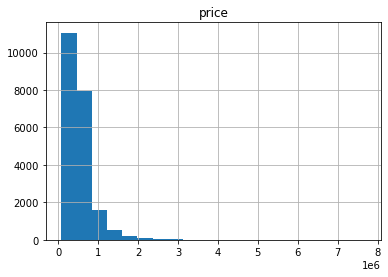

In [7]:
df.hist('price', bins=20);

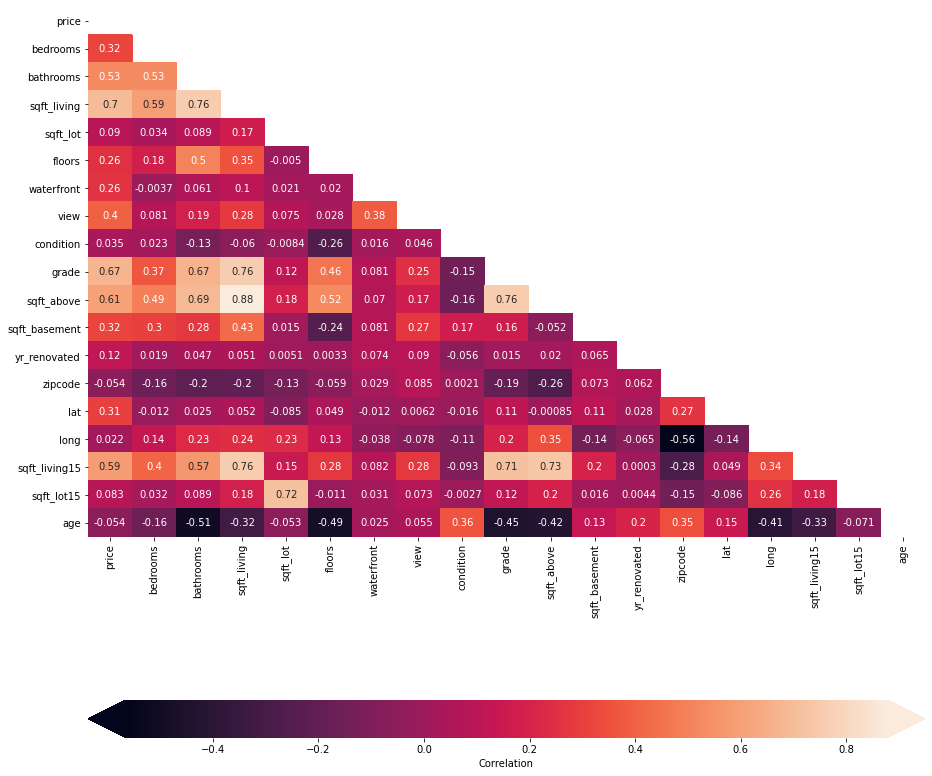

In [8]:
fig, ax = plt.subplots(figsize  =(15,15))
sns.heatmap(
            df.corr(), 
            ax=ax, 
            annot=True, 
            mask=np.triu(np.ones_like(df.corr(), dtype=bool)),
            cbar_kws={"label": "Correlation", "orientation": "horizontal", "pad": .2, "extend": "both"}
);

In [9]:
price_corrs = df.corr()['price'].map(abs).sort_values(ascending=False)
price_corrs

price            1.000000
sqft_living      0.701599
grade            0.668320
sqft_above       0.605719
sqft_living15    0.585329
bathrooms        0.525063
view             0.395739
sqft_basement    0.319077
bedrooms         0.315236
lat              0.307863
waterfront       0.259222
floors           0.257069
yr_renovated     0.117985
sqft_lot         0.090341
sqft_lot15       0.083194
age              0.054224
zipcode          0.053626
condition        0.035367
long             0.022428
Name: price, dtype: float64

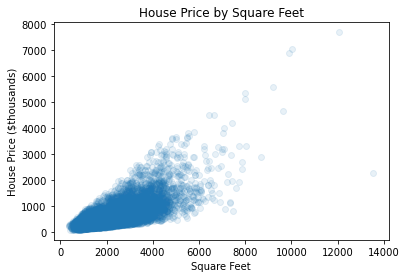

In [10]:
fig, ax = plt.subplots()
ax.scatter(df.sqft_living, df.price, alpha=.1)
ax.set_xlabel('Square Feet')
ax.set_yticks(range(0,9000000,1000000))
ax.set_yticklabels(range(0,9000,1000))
ax.set_ylabel('House Price ($thousands)')
ax.set_title('House Price by Square Feet');

## Baseline model using 'sqft_living' as the only feature

In [11]:
#Statsmodels
y = df.price
X = sm.add_constant(df.sqft_living)
stats_model_baseline = sm.OLS(endog=y, exog=X).fit()
stats_model_baseline.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.492
Model:                            OLS   Adj. R-squared:                  0.492
Method:                 Least Squares   F-statistic:                 2.087e+04
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:24:21   Log-Likelihood:            -2.9911e+05
No. Observations:               21533   AIC:                         5.982e+05
Df Residuals:                   21531   BIC:                         5.982e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===============================================================================
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const       -4.218e+04   4404.621     -9.575      0.000   -5.08e+04   -3.35e+04
sqft_living   279.9379      1.938    144.475      0.000     276.140     283.736
==============================================================================
Omnibus:                    14581.827   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           516123.571
Skew:                           2.781   Prob(JB):                         0.00
Kurtosis:                      26.331   Cond. No.                     5.63e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 5.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

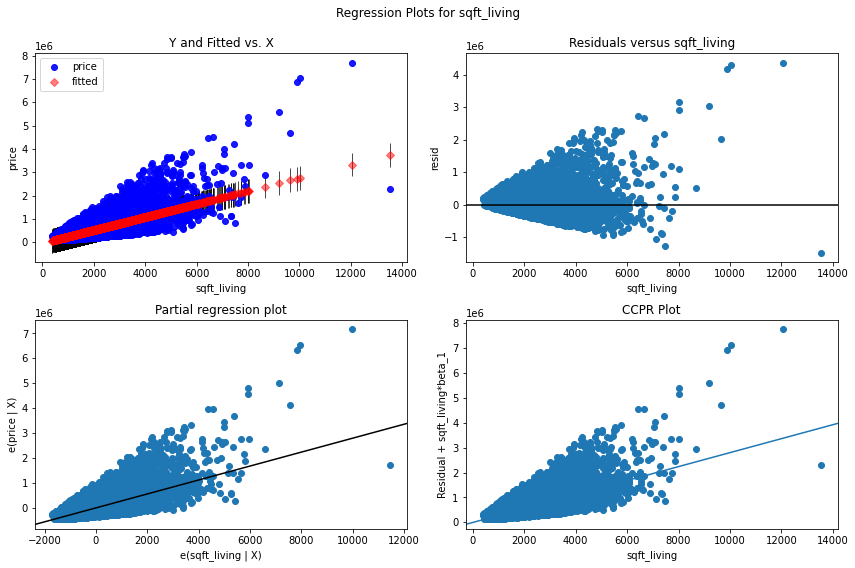

In [12]:
sm.graphics.plot_regress_exog(stats_model_baseline, 'sqft_living', fig = plt.figure(figsize=(12,8)));

In [13]:
#SkLearn
y = df.price
X = df.sqft_living.values.reshape(-1,1)
sk_model_baseline = LinearRegression()
sk_model_baseline.fit(X, y)
score = sk_model_baseline.score(X, y)
coef = sk_model_baseline.coef_
intercept = sk_model_baseline.intercept_
print('R2 score:              ', round(score, 3))
print('sqft_living coef.:     ', round(coef[0], 3))
print('Intercept:            ', round(intercept, 2))

R2 score:               0.492
sqft_living coef.:      279.938
Intercept:             -42175.63


# OLS

In [14]:
X = df[['bedrooms','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
       'grade','sqft_above','sqft_basement','sqft_living15','sqft_lot15']]
y = df['price']

X = sm.add_constant(X)

stats_model_1 = sm.OLS(endog=y, exog=X).fit()
stats_model_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.607
Model:                            OLS   Adj. R-squared:                  0.607
Method:                 Least Squares   F-statistic:                     2560.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:24:27   Log-Likelihood:            -2.9634e+05
No. Observations:               21533   AIC:                         5.927e+05
Df Residuals:                   21519   BIC:                         5.928e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const         -6.836e+05   1.75e+04    -38.988      0.000   -7.18e+05   -6.49e+05
bedrooms      -1.921e+04   1125.862    -17.064      0.000   -2.14e+04    -1.7e+04
bedrooms      -1.921e+04   1125.862    -17.064      0.000   -2.14e+04    -1.7e+04
bathrooms     -1.435e+04   3491.620     -4.108      0.000   -2.12e+04   -7501.485
sqft_living     168.6716     20.578      8.197      0.000     128.337     209.006
sqft_lot          0.0238      0.054      0.437      0.662      -0.083       0.131
floors        -2762.1291   3982.812     -0.694      0.488   -1.06e+04    5044.479
waterfront     5.945e+05   2.07e+04     28.660      0.000    5.54e+05    6.35e+05
view           6.167e+04   2374.555     25.972      0.000     5.7e+04    6.63e+04
condition      5.423e+04   2525.821     21.469      0.000    4.93e+04    5.92e+04
grade           1.01e+05   2372.780     42.563      0.000    9.63e+04    1.06e+05
sqft_above       19.4246     20.563      0.945      0.345     -20.880      59.730
sqft_basement    48.8422     20.416      2.392      0.017       8.826      88.859
sqft_living15    10.5444      3.820      2.760      0.006       3.057      18.032
sqft_lot15       -0.7638      0.083     -9.177      0.000      -0.927      -0.601
==============================================================================
Omnibus:                    15491.217   Durbin-Watson:                   1.981
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           909496.204
Skew:                           2.871   Prob(JB):                         0.00
Kurtosis:                      34.316   Cond. No.                     4.57e+17
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The smallest eigenvalue is 2.64e-22. This might indicate that there are
strong multicollinearity problems or that the design matrix is singular.
"""

# SkLearn Starts Here

In [15]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'age'],
      dtype='object')

## Baseline Model

In [16]:
df.isna().sum()

price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
age              0
dtype: int64

In [17]:
X = df.drop(['price', 'age'], axis = 1)
y = df.price
X, y
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [19]:
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error, r2_score
from sklearn.dummy import DummyRegressor
lm = LinearRegression().fit(X_train, y_train)
lm_dummy_mean = DummyRegressor(strategy = 'mean').fit(X_train, y_train)
y_predict = lm.predict(X_test)
y_predict_dummy_mean = lm_dummy_mean.predict(X_test)
# print(lm.coef_)
print(r2_score(y_test, y_predict))

0.6749653844713042


### Model 1:  including 'age'

In [15]:
# Change the X to the revelant colums
X = df.drop(['price'], axis = 1)
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

0.9586206695291681

In [20]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)
lr.coef_[0]
lr.intercept_
rmse_lr = mean_squared_error(y_test, pred_lr, squared=False)
train_score_lr, test_score_lr, rmse_lr

(0.683435208417577, 0.6749653844713042, 211747.21037508108)

### Model 2: log transform 'price'

In [21]:
X = df.drop(['price'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [22]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)
lr.coef_[0]
lr.intercept_
rmse_lr = mean_squared_error(y_test, pred_lr, squared=False)
train_score_lr, test_score_lr, rmse_lr

(0.7716633054371127, 0.7649036245277617, 0.25717593403330175)

### Model 3:  creating dummy columns for zip code

In [23]:
df = df.join(pd.get_dummies(df['zipcode'], prefix = 'x', drop_first = True))

In [26]:
X = df.drop(['price'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [27]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)
lr.coef_[0]
lr.intercept_
rmse_lr = mean_squared_error(y_test, pred_lr, squared=False)
train_score_lr, test_score_lr, rmse_lr

(0.8783623094453447, 0.8702059345827169, 0.19108859922879654)

In [33]:
df.columns

Index(['price', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'age', 'x_98002', 'x_98003', 'x_98004',
       'x_98005', 'x_98006', 'x_98007', 'x_98008', 'x_98010', 'x_98011',
       'x_98014', 'x_98019', 'x_98022', 'x_98023', 'x_98024', 'x_98027',
       'x_98028', 'x_98029', 'x_98030', 'x_98031', 'x_98032', 'x_98033',
       'x_98034', 'x_98038', 'x_98039', 'x_98040', 'x_98042', 'x_98045',
       'x_98052', 'x_98053', 'x_98055', 'x_98056', 'x_98058', 'x_98059',
       'x_98065', 'x_98070', 'x_98072', 'x_98074', 'x_98075', 'x_98077',
       'x_98092', 'x_98102', 'x_98103', 'x_98105', 'x_98106', 'x_98107',
       'x_98108', 'x_98109', 'x_98112', 'x_98115', 'x_98116', 'x_98117',
       'x_98118', 'x_98119', 'x_98122', 'x_98125', 'x_98126', 'x_98133',
       'x_98136', 'x_98144', 'x_98146', 'x_98148', 'x_98

In [34]:
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1776.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:50:36   Log-Likelihood:                 5816.2
No. Observations:               21533   AIC:                        -1.146e+04
Df Residuals:                   21446   BIC:                        -1.076e+04
Df Model:                          86                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0227      0.001    -20.735      0.000      -0.025      -0.021
bedrooms          0.0030      0.002      1.596      0.110      -0.001       0.007
bathrooms         0.0416      0.003     13.689      0.000       0.036       0.048
sqft_living       0.0001   1.67e-05      6.625      0.000    7.77e-05       0.000
sqft_lot       6.072e-07   4.43e-08     13.711      0.000     5.2e-07    6.94e-07
floors           -0.0300      0.004     -8.230      0.000      -0.037      -0.023
waterfront        0.4589      0.017     26.977      0.000       0.426       0.492
view              0.0602      0.002     29.985      0.000       0.056       0.064
condition         0.0573      0.002     25.891      0.000       0.053       0.062
grade             0.0936      0.002     44.492      0.000       0.089       0.098
sqft_above     8.705e-05   1.67e-05      5.216      0.000    5.43e-05       0.000
sqft_basement  1.388e-05   1.65e-05      0.842      0.400   -1.84e-05    4.62e-05
yr_renovated   3.939e-05   3.69e-06     10.685      0.000    3.22e-05    4.66e-05
zipcode          -0.0006   7.22e-05     -8.515      0.000      -0.001      -0.000
lat               0.5214      0.073      7.130      0.000       0.378       0.665
long             -0.3815      0.053     -7.264      0.000      -0.484      -0.279
sqft_living15  8.424e-05   3.33e-06     25.282      0.000    7.77e-05    9.08e-05
sqft_lot15     7.774e-08   6.97e-08      1.115      0.265    -5.9e-08    2.14e-07
age               0.0005   7.41e-05      6.544      0.000       0.000       0.001
x_98002          -0.0139      0.017     -0.835      0.404      -0.047       0.019
x_98003          -0.0089      0.015     -0.600      0.549      -0.038       0.020
x_98004           0.9494      0.027     35.077      0.000       0.896       1.002
x_98005           0.5988      0.029     20.700      0.000       0.542       0.655
x_98006           0.5254      0.024     22.197      0.000       0.479       0.572
x_98007           0.5310      0.030     17.791      0.000       0.473       0.590
x_98008           0.5396      0.028     19.024      0.000       0.484       0.595
x_98010           0.3356      0.026     13.043      0.000       0.285       0.386
x_98011           0.2428      0.037      6.604      0.000       0.171       0.315
x_98014           0.2744      0.041      6.730      0.000       0.194       0.354
x_98019           0.2350      0.040      5.863      0.000       0.156       0.314
x_98022           0.2011      0.023      8.663      0.000       0.156       0.247
x_98023          -0.0605      0.013     -4.533      0.000      -0.087      -0.034
x_98024           0.4327      0.036     11.953      0.000       0.362       0.504
x_98027           0.4870      0.025     19.727      0.000       0.439       0.535
x_98028           0.2086      0.035      5.917   

### Model 4:  dropping features with high p_values


In [35]:
X = df.drop(['price', 'x_98002', 'x_98003', 'sqft_basement', 'sqft_lot15'], axis = 1)
y = df['price'] 
y = np.log(y)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [36]:
lr = LinearRegression()
lr.fit(X_train, y_train)
pred_lr = lr.predict(X_test)
train_score_lr = lr.score(X_train, y_train)
test_score_lr = lr.score(X_test, y_test)
lr.coef_[0]
lr.intercept_
rmse_lr = mean_squared_error(y_test, pred_lr, squared=False)

In [37]:
train_score_lr, test_score_lr, rmse_lr

(0.8783495053881852, 0.8702421515098159, 0.19106193728286688)

In [38]:
X = sm.add_constant(X)
sm.OLS(y, X).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  price   R-squared:                       0.877
Model:                            OLS   Adj. R-squared:                  0.876
Method:                 Least Squares   F-statistic:                     1840.
Date:                Tue, 13 Jul 2021   Prob (F-statistic):               0.00
Time:                        11:56:28   Log-Likelihood:                 5815.0
No. Observations:               21533   AIC:                        -1.146e+04
Df Residuals:                   21449   BIC:                        -1.079e+04
Df Model:                          83                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const           476.6149    726.953      0.656      0.512    -948.268    1901.497
bedrooms          0.0029      0.002      1.552      0.121      -0.001       0.006
bathrooms         0.0415      0.003     13.660      0.000       0.036       0.047
sqft_living       0.0001   4.11e-06     30.197      0.000       0.000       0.000
sqft_lot       6.397e-07   3.37e-08     18.969      0.000    5.74e-07    7.06e-07
floors           -0.0301      0.004     -8.271      0.000      -0.037      -0.023
waterfront        0.4589      0.017     26.976      0.000       0.426       0.492
view              0.0602      0.002     29.982      0.000       0.056       0.064
condition         0.0573      0.002     25.894      0.000       0.053       0.062
grade             0.0936      0.002     44.524      0.000       0.090       0.098
sqft_above     7.342e-05   4.19e-06     17.515      0.000    6.52e-05    8.16e-05
yr_renovated   3.938e-05   3.69e-06     10.682      0.000    3.22e-05    4.66e-05
zipcode          -0.0055      0.007     -0.739      0.460      -0.020       0.009
lat               0.5219      0.073      7.137      0.000       0.379       0.665
long             -0.3865      0.051     -7.627      0.000      -0.486      -0.287
sqft_living15  8.457e-05   3.32e-06     25.448      0.000    7.81e-05    9.11e-05
age               0.0005   7.41e-05      6.534      0.000       0.000       0.001
x_98004           0.9660      0.030     32.042      0.000       0.907       1.025
x_98005           0.6206      0.036     17.177      0.000       0.550       0.691
x_98006           0.5518      0.038     14.554      0.000       0.478       0.626
x_98007           0.5625      0.048     11.792      0.000       0.469       0.656
x_98008           0.5762      0.053     10.852      0.000       0.472       0.680
x_98010           0.3840      0.066      5.805      0.000       0.254       0.514
x_98011           0.2933      0.076      3.846      0.000       0.144       0.443
x_98014           0.3439      0.100      3.447      0.001       0.148       0.539
x_98019           0.3270      0.134      2.442      0.015       0.065       0.589
x_98022           0.3078      0.152      2.021      0.043       0.009       0.606
x_98023           0.0480      0.157      0.307      0.759      -0.259       0.355
x_98024           0.5506      0.169      3.252      0.001       0.219       0.882
x_98027           0.6170      0.189      3.270      0.001       0.247       0.987
x_98028           0.3416      0.196      1.740      0.082      -0.043       0.726
x_98029           0.7147      0.204      3.503      0.000       0.315       1.115
x_98030           0.2120      0.209      1.012      0.312      -0.199       0.623
x_98031           0.2167      0.217      0.999      0.318      -0.208       0.642
x_98032           0.0942      0.224      0.421   

We will replace the two zip codes because removing them increases the pvalues for most of the other zip codes.

## Linear Regression

### Create a linear regression function

In [16]:
def lr(X, y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    lr = LinearRegression()
    lr.fit(X_train, y_train)

    train_score = lr.score(X_train, y_train)
    test_score = lr.score(X_test, y_test)

    print('Train Score: ', train_score)
    print('Test Score:  ', test_score)

    price_predict = lr.predict(X_test)
    plt.scatter(y_test, price_predict)
    plt.xlabel('Prices from y_test')
    plt.ylabel('Prices predicted');
    plt.title('Predicted vs Actual Prices');

### All Features (after dropping null values from 'yr_renovated)'

Train Score:  0.700595770964173
Test Score:   0.7016990693134955


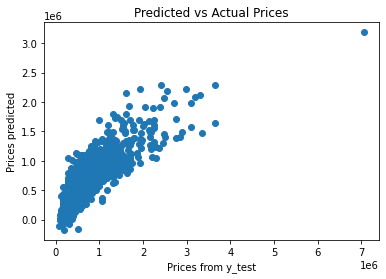

In [20]:
df1 = df.dropna()
X = df1.drop(['price'], axis=1)
y = df1['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

train_score = lr.score(X_train, y_train)
test_score = lr.score(X_test, y_test)

print('Train Score: ', train_score)
print('Test Score:  ', test_score)

price_predict = lr.predict(X_test)
plt.scatter(y_test, price_predict)
plt.xlabel('Prices from y_test')
plt.ylabel('Prices predicted');
plt.title('Predicted vs Actual Prices');

### Linear Regression (drop: 'date', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long')

Train Score:  0.6044754511583585
Test Score:   0.7016990693134955


Text(0.5, 1.0, 'Predicted vs Actual Prices')

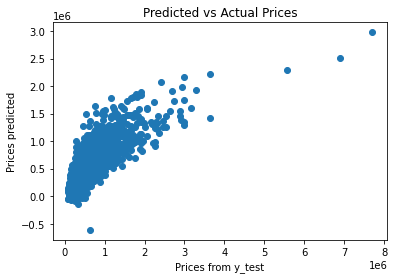

In [21]:
X = df[['bedrooms','bedrooms','bathrooms','sqft_living','sqft_lot','floors','waterfront','view','condition',
       'grade','sqft_above','sqft_basement','sqft_living15','sqft_lot15']]
y = df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

lr = LinearRegression()
lr.fit(X_train, y_train)

train_score = lr.score(X_train, y_train)
train_score = lr.score(X_test, y_test)

print('Train Score: ', train_score)
print('Test Score:  ', test_score)

price_predict = lr.predict(X_test)
plt.scatter(y_test, price_predict)
plt.xlabel('Prices from y_test')
plt.ylabel('Prices predicted');
plt.title('Predicted vs Actual Prices')